In [1]:
import configparser


from PIL import Image
import io
import os
import numpy as np

import boto3

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import ArrayType, StringType, IntegerType, DoubleType, DataType, FloatType
from pyspark.sql.functions import udf

# Taches machine learning
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.feature import PCA

import matplotlib.pyplot as plt

In [2]:
aws_profile = "default"

config = configparser.ConfigParser()
config.read(os.path.expanduser("../../.aws/credentials"))
access_id = config.get(aws_profile, "aws_access_key_id".upper()) 
access_key = config.get(aws_profile, "aws_secret_access_key".upper())

In [3]:
session = boto3.Session(
    aws_access_key_id=access_id,
    aws_secret_access_key=access_key,
)

In [4]:
s3 = session.resource('s3')
bucket = s3.Bucket("fruits-oc-p08")
obj = bucket.Object(key='sample/apple_golden_1/r0_107.jpg')
response = obj.get()
file_stream = response[u'Body']
im = Image.open(file_stream)
im = im.resize((20,20))
im_arr = np.asarray(im)

In [5]:
im

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('APP_P08') \
                    .getOrCreate()

22/02/25 13:48:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [7]:
spark

In [8]:
sc = spark.sparkContext

In [9]:
paths = []
for file in bucket.objects.all():
    paths.append(file.key)
    
rdd_paths = sc.parallelize(paths)
row_rdd_paths = rdd_paths.map(lambda x: Row(x))

In [10]:
images_df = spark.createDataFrame(row_rdd_paths, ['path'])

In [11]:
# images_df.show(6)

In [12]:
def get_categ(path):
    folder_name = path.split('/')[1]
    categ = folder_name.split('_1')[0]
    return categ

In [13]:
udf_categ = udf(get_categ, StringType())
images_df = images_df.withColumn('categ', udf_categ('path'))

In [14]:
images_df.show(6, truncate=60)

+---------------------------------+-------------+
|                             path|        categ|
+---------------------------------+-------------+
| sample/apple_golden_1/r0_107.jpg| apple_golden|
| sample/apple_golden_1/r0_171.jpg| apple_golden|
| sample/apple_golden_1/r1_147.jpg| apple_golden|
| sample/apple_golden_1/r1_175.jpg| apple_golden|
| sample/apple_golden_1/r1_239.jpg| apple_golden|
|sample/cabbage_white_1/r0_139.jpg|cabbage_white|
+---------------------------------+-------------+
only showing top 6 rows



In [15]:
def get_image(path):
    s3 = session.resource('s3')
    bucket = s3.Bucket("fruits-oc-p08")
    obj = bucket.Object(key=path)
    response = obj.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    im_resized = im.resize((20, 20))
    return np.array(im_resized).flatten().tolist()

In [16]:
len(get_image('sample/apple_golden_1/r0_107.jpg'))

1200

In [17]:
udf_image = udf(get_image)

In [18]:
images_df = images_df.withColumn('data', udf_image('path'))

In [19]:
images_df.show(6, truncate=60)

[Stage 2:>                                                          (0 + 1) / 1]

+---------------------------------+-------------+------------------------------------------------------------+
|                             path|        categ|                                                        data|
+---------------------------------+-------------+------------------------------------------------------------+
| sample/apple_golden_1/r0_107.jpg| apple_golden|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
| sample/apple_golden_1/r0_171.jpg| apple_golden|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
| sample/apple_golden_1/r1_147.jpg| apple_golden|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
| sample/apple_golden_1/r1_175.jpg| apple_golden|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
| sample/apple_golden_1/r1_239.jpg| apple_golden|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
|sample/cabbage_white_1/r0_139.jpg|cabbage_white|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2...|
+

In [20]:
# conversion format vecteur dense
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
images_df = images_df.withColumn('data', ud_f('data'))

In [21]:
#standardisation des données
standardizer = StandardScaler(inputCol="data", outputCol="data_scale", withStd=True, withMean=True)
model_std = standardizer.fit(images_df)
images_df = model_std.transform(images_df)

In [22]:
images_df.show(6)

[Stage 4:>                                                          (0 + 1) / 1]

+--------------------+-------------+--------------------+--------------------+
|                path|        categ|                data|          data_scale|
+--------------------+-------------+--------------------+--------------------+
|sample/apple_gold...| apple_golden|[255.0,255.0,255....|[0.29727137307215...|
|sample/apple_gold...| apple_golden|[255.0,255.0,255....|[0.29727137307215...|
|sample/apple_gold...| apple_golden|[255.0,255.0,255....|[0.29727137307215...|
|sample/apple_gold...| apple_golden|[255.0,255.0,255....|[0.29727137307215...|
|sample/apple_gold...| apple_golden|[255.0,255.0,255....|[0.29727137307215...|
|sample/cabbage_wh...|cabbage_white|[255.0,255.0,255....|[0.29727137307215...|
+--------------------+-------------+--------------------+--------------------+
only showing top 6 rows



In [23]:
images_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- categ: string (nullable = true)
 |-- data: vector (nullable = true)
 |-- data_scale: vector (nullable = true)



In [24]:
images_df = images_df.drop('data')

In [25]:
images_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- categ: string (nullable = true)
 |-- data_scale: vector (nullable = true)



In [26]:
images_df.show(6)

[Stage 5:>                                                          (0 + 1) / 1]

+--------------------+-------------+--------------------+
|                path|        categ|          data_scale|
+--------------------+-------------+--------------------+
|sample/apple_gold...| apple_golden|[0.29727137307215...|
|sample/apple_gold...| apple_golden|[0.29727137307215...|
|sample/apple_gold...| apple_golden|[0.29727137307215...|
|sample/apple_gold...| apple_golden|[0.29727137307215...|
|sample/apple_gold...| apple_golden|[0.29727137307215...|
|sample/cabbage_wh...|cabbage_white|[0.29727137307215...|
+--------------------+-------------+--------------------+
only showing top 6 rows



In [27]:
pca_obj = PCA(k=100, inputCol='data_scale')
pca_model = pca_obj.fit(images_df)

[Stage 9:>                                                          (0 + 2) / 2]22/02/25 13:49:04 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/02/25 13:49:04 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/02/25 13:49:04 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/02/25 13:49:04 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Text(0, 0.5, 'Variance cumulée')

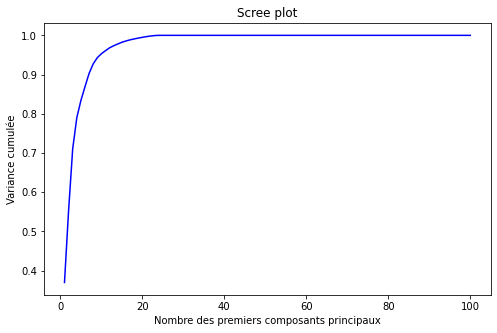

In [28]:
eVc = pca_model.explainedVariance.cumsum()
#plt.rcParams['figure.facecolor']='w'
plt.figure(figsize=(8,5))
plt.plot(range(1,len(eVc)+1), eVc, color='b', linestyle='-')
plt.title('Scree plot')
plt.xlabel('Nombre des premiers composants principaux')
plt.ylabel('Variance cumulée')

In [29]:
pca_obj = PCA(k=20, inputCol='data_scale', outputCol='pca_features')
pca_model = pca_obj.fit(images_df)

In [30]:
images_df = pca_model.transform(images_df)

In [31]:
images_df.show(6)

[Stage 14:>                                                         (0 + 1) / 1]

+--------------------+-------------+--------------------+--------------------+
|                path|        categ|          data_scale|        pca_features|
+--------------------+-------------+--------------------+--------------------+
|sample/apple_gold...| apple_golden|[0.29727137307215...|[4.98322515727135...|
|sample/apple_gold...| apple_golden|[0.29727137307215...|[9.61064370313451...|
|sample/apple_gold...| apple_golden|[0.29727137307215...|[6.13758904996988...|
|sample/apple_gold...| apple_golden|[0.29727137307215...|[7.46652431865648...|
|sample/apple_gold...| apple_golden|[0.29727137307215...|[8.93427882146846...|
|sample/cabbage_wh...|cabbage_white|[0.29727137307215...|[6.35674010172881...|
+--------------------+-------------+--------------------+--------------------+
only showing top 6 rows



In [33]:
images_df_pandas = images_df.toPandas()

In [36]:
s3_client = boto3.client("s3", region_name='eu-west-3')
images_df_pandas.to_csv("s3://fruits-oc-p08/results/results_sample_1.csv")